In [1]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
torch.set_grad_enabled(True)
import os
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms

c:\Users\jarne\miniconda3\envs\deepproblog\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
script_dir = os.getcwd()
emotion_processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
multi_face_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

scene_weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
scene_checkpoint = torch.hub.load_state_dict_from_url(scene_weights_url, map_location="cpu")

original_scene_model = models.resnet18(num_classes=365)
original_scene_model.fc = nn.Linear(original_scene_model.fc.in_features, 365)
scene_state_dict = {k.replace("module.", ""): v for k, v in scene_checkpoint["state_dict"].items()}
original_scene_model.load_state_dict(scene_state_dict)
original_scene_model.eval()

# Preprocessing, the standard torchvision normalization for ResNet, VGG, DenseNet...
scene_tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [3]:
from deepproblog.network import Network 
import torch.nn.functional as F

original_hf_emotion_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

class MultiFaceWrapperFlat(nn.Module):
    def __init__(self, hf_model, max_faces=3):
        super().__init__()
        self.hf_model = hf_model
        self.max_faces = max_faces

    def forward(self, x):
        if isinstance(x, list) and len(x) == 1 and isinstance(x[0], list):
            face_tensors = x[0]
        elif isinstance(x, list):
            face_tensors = x
        else:
            face_tensors = [x]
        
        face_probs_list = []
        
        for i, face_tensor in enumerate(face_tensors[:self.max_faces]):
            if torch.is_tensor(face_tensor):
                face_batch = face_tensor.unsqueeze(0)
                outputs = self.hf_model(face_batch)
                probs = F.softmax(outputs.logits, dim=-1)
                face_probs_list.append(probs.squeeze(0)) 
        
        while len(face_probs_list) < self.max_faces:
            face_probs_list.append(torch.zeros(7, requires_grad=False))
        
        result = torch.cat(face_probs_list, dim=0)
        return result

original_hf_emotion_model.eval()
for p in original_hf_emotion_model.parameters():
    p.requires_grad = False

max_faces = 3
multi_face_model = MultiFaceWrapperFlat(original_hf_emotion_model, max_faces=max_faces)

# We freeze the network for now because it is already pretrained
# Freeze multi-face (no optimizer)
multi_face_model.eval()
for p in multi_face_model.parameters():
    p.requires_grad = False
multi_face_network = Network(multi_face_model, "multi_face_net", batching=False)
multi_face_network.optimizer = None  # no training
    
class SceneFeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.backbone = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x, dim=0)
        elif len(x.shape) == 3:
            x = x.unsqueeze(0)
            
        feats = self.backbone(x)
        feats = feats.view(feats.size(0), -1)

        return feats

scene_model = SceneFeatureExtractor(original_scene_model)
# Freeze scene feature extractor
scene_model.eval()
for p in scene_model.parameters():
    p.requires_grad = False
scene_network = Network(scene_model, "scene_net", batching=True)
scene_network.optimizer = None  # no training

class Scene2EmotionNet(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=64, output_dim=7, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

        # Use Kaiming initialization for ReLU
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc2(x)

        probs = F.softmax(logits, dim=-1)
        return probs
    
scene2emo_model = Scene2EmotionNet()
# Trainable adapter
scene2emo_model.train()
scene2emo_network = Network(scene2emo_model, "scene2emo_net", batching=True)
scene2emo_network.optimizer = torch.optim.Adam(scene2emo_network.parameters(), lr=1e-4, weight_decay=1e-5)

In [4]:
import os
import pandas as pd
import random
from io import StringIO
import matplotlib.pyplot as plt
from IPython.display import display
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image

script_dir = os.getcwd()
labels_dir = os.path.join(script_dir, "../data/findingemo/labels")
base_findingemo_dir = os.path.join(script_dir, "../data/findingemo")
csv_path = os.path.join(labels_dir, "annotations_cleaned.csv")
df_findingEmo = pd.read_csv(csv_path)

In [5]:
# Get the different emotions from FindingEmo
emotion_labels_findingemo = df_findingEmo['emotion'].unique().tolist()
emotion_to_idx = {emotion: idx for idx, emotion in enumerate(emotion_labels_findingemo)}
print(emotion_labels_findingemo)

['Trust', 'Interest', 'Apprehension', 'Anticipation', 'Anger', 'Joy', 'Grief', 'Serenity', 'Boredom', 'Ecstasy', 'Fear', 'Vigilance', 'Sadness', 'Rage', 'Annoyance', 'Acceptance', 'Terror', 'Amazement', 'Surprise', 'Pensiveness', 'Admiration', 'Loathing', 'Distraction', 'Disgust']


In [6]:
# train_test split
from sklearn.model_selection import train_test_split
# Shuffle the dataset
df_findingEmo = df_findingEmo.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, test_df = train_test_split(df_findingEmo, test_size=0.2, random_state=42)

# reset indexes
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df = train_df.iloc[:50]

In [7]:
class FindingEmoFaceImages(object):
    def __init__(self, subset, prints=False):
        self.subset = subset
        # Use OpenCV instead of MTCNN - much faster and less memory
        self.face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.face_tensors = {}
        self.prints = prints

        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()

    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        try:
            image_path = self.dataframe["image_path"][index]
            if image_path.startswith('/'):
                image_path = image_path[1:]
            
            img_path = os.path.join(base_findingemo_dir, image_path)
            
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Failed to load image: {img_path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize large images
            height, width = img.shape[:2]
            if height > 300 or width > 300:
                scale = 300 / max(height, width)
                new_height = int(height * scale)
                new_width = int(width * scale)
                img = cv2.resize(img, (new_width, new_height))
            
            # OpenCV face detection (much more memory efficient)
            faces = self.face_detector.detectMultiScale(
                img, 
                scaleFactor=1.3, 
                minNeighbors=6, 
                minSize=(50, 50)
            )

            face_tensors = []
            face_pils = []

            if len(faces) > 0:
                # Only take the largest face
                faces = sorted(faces, key=lambda x: x[2] * x[3], reverse=True)[:max_faces]
                
                for (x, y, w, h) in faces:
                    # Add padding to face coordinates
                    x = max(0, x - 10)
                    y = max(0, y - 10)
                    w = min(img.shape[1] - x, w + 20)
                    h = min(img.shape[0] - y, h + 20)
                    
                    face_crop = img[y:y+h, x:x+w]
                    
                    # Skip very small faces
                    if face_crop.shape[0] < 40 or face_crop.shape[1] < 40:
                        continue

                    face_pil = Image.fromarray(face_crop)
                    face_pils.append(face_pil)
                    
                    # Process with explicit format to avoid ambiguity
                    face_input = emotion_processor(
                        images=face_pil, 
                        return_tensors="pt",
                        do_rescale=True,
                        do_normalize=True
                    )
                    face_tensors.append(face_input['pixel_values'].squeeze(0))

                # Fallback to whole image if no valid faces
                if len(face_tensors) == 0:
                    img_pil = Image.fromarray(img)
                    face_pils = [img_pil]
                    face_input = emotion_processor(
                        images=img_pil, 
                        return_tensors="pt",
                        do_rescale=True,
                        do_normalize=True
                    )
                    face_tensors = [face_input['pixel_values'].squeeze(0)]
        
            if self.prints:
                self.face_tensors[index] = face_pils if 'face_pils' in locals() else [Image.fromarray(img)]
                
            return face_tensors
    
        except Exception as e:
            print(f"Error processing sample {index}: {e}")
            # Return a dummy tensor to avoid crashing
            dummy_img = Image.new('RGB', (224, 224), color='gray')
            face_input = emotion_processor(images=dummy_img, return_tensors="pt")
            return [face_input['pixel_values'].squeeze(0)]
    
    def print_faces_and_image(self, i):
        _ = self.__getitem__(i)

        if i in self.face_tensors:
            face_tensors = self.face_tensors[i]
            num_faces = len(face_tensors)
            if num_faces > 0:
                plt.figure(figsize=(8, 3))
            for j, face_tensor in enumerate(face_tensors):
                plt.subplot(1, num_faces, j + 1)
                plt.imshow(face_tensor)
                plt.title(f'Face {j}')
                plt.axis('off')
            plt.show()

        # Print the original image
        image_path = self.dataframe["image_path"][i]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        img_path = os.path.join(base_findingemo_dir, image_path)
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title('Image: ' + str(i) + ' : ' + self.dataframe["emotion"][i])
        plt.axis('off')
        plt.show()

class FindingEmoSceneImages(object):
    def __init__(self, subset):
        self.subset = subset
        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()
            
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        image_path = self.dataframe["image_path"][index]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(base_findingemo_dir, image_path)
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
            
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img)
        
        # Use scene transforms for scene model
        scene_tensor = scene_tf(img_pil)
        return scene_tensor

# Create separate instances
FindingEmoFace_train_ex = FindingEmoFaceImages("train", prints=True)
FindingEmoFace_train = FindingEmoFaceImages("train")
FindingEmoFace_test = FindingEmoFaceImages("test")
FindingEmoScene_train = FindingEmoSceneImages("train") 
FindingEmoScene_test = FindingEmoSceneImages("test")

In [8]:
emotion_categories = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [9]:
# Mapping for the scene categories. Read them from ../data/places365/categories_places365.txt
scene_categories = []
with open(os.path.join(script_dir, "../data/places365/categories_places365.txt")) as f:
    for line in f:
        scene = line.strip().split(' ')[0][3:]
        scene_categories.append(scene)

model_scene_to_index = {scene: idx for idx, scene in enumerate(scene_categories)}

In [10]:
from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.dataset import Dataset, DataLoader
from torch.utils.data import Dataset as TorchDataset
from problog.logic import Term, Constant, Var
from deepproblog.query import Query
from deepproblog.train import train_model

In [11]:
num_emotions = len(emotion_categories) * max_faces
num_scenes = len(scene_categories)

emotion_indices = list(range(num_emotions))
scene_indices = list(range(num_scenes))

In [12]:
train_indices = list(range(len(train_df))) 
test_indices = list(range(len(test_df))) 

In [13]:
from deepproblog.engines import ApproximateEngine, ExactEngine
# Create model
model = Model(
    os.path.join(script_dir, "model.pl"),
    [multi_face_network, scene_network, scene2emo_network]
)
model.set_engine(ExactEngine(model), cache=True)
# from deepproblog.engines.prolog_engine.heuristics import PartialProbability
# model.set_engine(ApproximateEngine(model, k=1, heuristic=PartialProbability(), exploration=False))

# Register tensor sources
model.add_tensor_source("train_face", FindingEmoFace_train)
model.add_tensor_source("test_face", FindingEmoFace_test)
model.add_tensor_source("train_scene", FindingEmoScene_train)
model.add_tensor_source("test_scene", FindingEmoScene_test)

Caching ACs


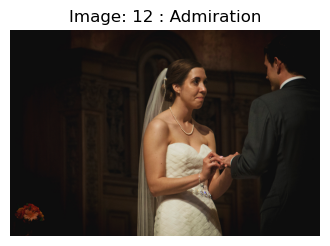

In [14]:
train_sample_idx = random.randint(0, len(train_df) - 1)
FindingEmoFace_train_ex.print_faces_and_image(train_sample_idx)

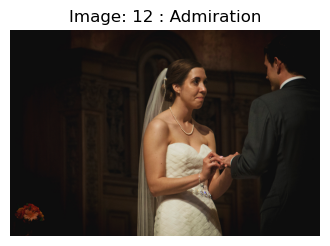

c:\Users\jarne\miniconda3\envs\deepproblog\lib\site-packages\deepproblog\semiring\graph_semiring.py:77: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  return -self.eps <= float(a) <= self.eps


Final Emotion Predictions:
Anger          : 0.2103
Rage           : 0.0701
Annoyance      : 0.0701
Fear           : 0.0399
Sadness        : 0.0292
Surprise       : 0.0290
Grief          : 0.0219
Pensiveness    : 0.0219
Apprehension   : 0.0199
Terror         : 0.0199
Vigilance      : 0.0199
Amazement      : 0.0181
Distraction    : 0.0181
Anticipation   : 0.0084
Serenity       : 0.0071
Joy            : 0.0071
Acceptance     : 0.0068
Disgust        : 0.0057
Boredom        : 0.0053
Ecstasy        : 0.0047
Interest       : 0.0035
Trust          : 0.0032
Loathing       : 0.0024
Admiration     : 0.0024


In [15]:
FindingEmoFace_train_ex.print_faces_and_image(train_sample_idx)

query = Query(
    Term("final_findingemo",
         Term("tensor", Term("train_face", Constant(train_sample_idx))),
         Term("tensor", Term("train_scene", Constant(train_sample_idx))),
         Var("FEIdx")),
    substitution={}
)

results_final = model.solve([query])
results_final_dict = results_final[0].result

# Sort by tensor values and display in a readable format
sorted_results = sorted(results_final_dict.items(), key=lambda x: x[1].item(), reverse=True)

print("Final Emotion Predictions:")
print("=" * 60)

for key, tensor_val in sorted_results:
    # Extract emotion index from the key
    key_str = str(key)
    emotion_idx = int(key_str.split(",")[-1][:-1])
    emotion_name = emotion_labels_findingemo[emotion_idx]
    probability = tensor_val.item()
    
    print(f"{emotion_name:15}: {probability:.4f}")

In [16]:
import json
from typing import Tuple

# Dataset for training
class FindingEmoDataset(Dataset, TorchDataset):
    def __init__(self, dataframe, subset_name, function_name="final_findingemo"):
        super(FindingEmoDataset, self).__init__()
        self.dataframe = dataframe.reset_index(drop=True)
        self.subset_name = subset_name
        self.function_name = function_name
        self.data = list(range(len(self.dataframe)))
    
    def __getitem__(self, index: int) -> Tuple[int, str, int]:
        sample_idx = self.data[index]
        emotion_name = self.dataframe.iloc[sample_idx]['emotion']
        emotion_idx = emotion_to_idx[emotion_name]
        return sample_idx, emotion_name, emotion_idx
    
    def __len__(self):
        return len(self.data)
    
    def to_query(self, i: int) -> Query:
        sample_idx = self.data[i]
        emotion_idx = emotion_to_idx[self.dataframe.iloc[sample_idx]['emotion']]
        
        query = Query(
            Term(self.function_name,
                 Term("tensor", Term(f"{self.subset_name}_face", Constant(sample_idx))),
                 Term("tensor", Term(f"{self.subset_name}_scene", Constant(sample_idx))),
                 Constant(emotion_idx)),  # Ground truth
            substitution={}
        )
        return query
    
    def get_label(self, i: int):
        sample_idx = self.data[i]
        emotion_name = self.dataframe.iloc[sample_idx]['emotion']
        return emotion_to_idx[emotion_name]
    
    def get_emotion_name(self, i: int):
        sample_idx = self.data[i]
        return self.dataframe.iloc[sample_idx]['emotion']

train_dataset = FindingEmoDataset(train_df, "train")
test_dataset = FindingEmoDataset(test_df, "test")

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Test the dataset
sample_idx, emotion_name, emotion_idx = train_dataset[0]
print(f"Sample 0: idx={sample_idx}, emotion='{emotion_name}', label={emotion_idx}")

# Test query generation
query = train_dataset.to_query(0)
print(f"Generated query: {query}")

Train dataset size: 50
Test dataset size: 4275
Sample 0: idx=0, emotion='Vigilance', label=11
Generated query: (1.0::final_findingemo(tensor(train_face(0)),tensor(train_scene(0)),11), {})


In [17]:
# Ensure output folders exist
snapshot_dir = os.path.join(script_dir, "snapshot")
log_dir = os.path.join(script_dir, "log")
os.makedirs(snapshot_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [18]:
import gc
import torch

# Add memory cleanup before training
def cleanup_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Memory cleaned up")

cleanup_memory()

Memory cleaned up


In [19]:
import torch.optim as optim
from deepproblog.train import train_model
from deepproblog.utils.stop_condition import EpochStop

loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [20]:
# train = train_model(model, loader, EpochStop(15), log_iter=50, profile=0)

from deepproblog.utils.stop_condition import StopOnPlateau

# Stop when loss stops improving
train = train_model(
    model, 
    loader, 
    StopOnPlateau(attribute="loss",patience=5, delta=0.01),  
     # Stop if loss doesn't improve by 0.01 for 5 iterations
    log_iter=50, 
    profile=0
)

Training  until plateau in loss
Iteration:  50 	s:6.6573 	Average Loss:  3.921409788131714
0.7157913089999776	0.37693762381614015	0.15080651511569854	0.6449461264030626
Iteration:  100 	s:4.4029 	Average Loss:  3.484719703197479
0.7157913089999776	0.37693762381614015	0.15080651511569854	0.6449461264030626
Iteration:  150 	s:4.2737 	Average Loss:  3.405636532306671
0.7157913089999776	0.37693762381614015	0.15080651511569854	0.6449461264030626
Iteration:  200 	s:4.5574 	Average Loss:  3.3272472405433655
0.7157913089999776	0.37693762381614015	0.15080651511569854	0.6449461264030626
Iteration:  250 	s:4.4104 	Average Loss:  3.4125073766708374
0.7157913089999776	0.37693762381614015	0.15080651511569854	0.6449461264030626
Iteration:  300 	s:4.3138 	Average Loss:  3.3028246688842775
0.7157913089999776	0.37693762381614015	0.15080651511569854	0.6449461264030626
Iteration:  350 	s:4.5102 	Average Loss:  3.3101376557350157
0.7157913089999776	0.37693762381614015	0.15080651511569854	0.6449461264030626

In [21]:
from json import dumps
from deepproblog.evaluate import get_confusion_matrix

# Save results
snapshot_path = os.path.join(snapshot_dir, "social_cognition" + ".pth")
model.save_state(snapshot_path)
print("Model snapshot saved to:", snapshot_path)

log_path = os.path.join(log_dir, "social_cognition")
train.logger.comment(dumps(model.get_hyperparameters()))
train.logger.comment("Accuracy {}".format(get_confusion_matrix(model, test_dataset, verbose=1).accuracy()))
train.logger.write_to_file(log_path)
print("Training log written to:", log_path) 

Model snapshot saved to: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\snapshot\social_cognition.pth


KeyboardInterrupt: 

In [ ]:
# snapshot_path = os.path.join(script_dir, "snapshot", "social_cognition.pth")

# if os.path.exists(snapshot_path):
#     print(f"Loading model from: {snapshot_path}")
#     model.load_state(snapshot_path)
# else:
#     print("Error loading model")

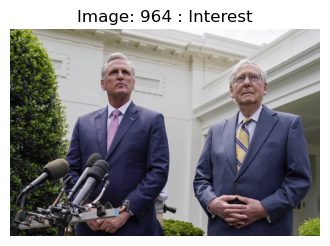

Enhanced Final Emotion Predictions (sorted by raw logits):
Joy            : 0.1031
Serenity       : 0.0836
Acceptance     : 0.0744
Ecstasy        : 0.0687
Boredom        : 0.0480
Trust          : 0.0424
Admiration     : 0.0344
Interest       : 0.0320
Sadness        : 0.0263
Grief          : 0.0197
Pensiveness    : 0.0197
Anticipation   : 0.0196
Anger          : 0.0168
Surprise       : 0.0098
Fear           : 0.0086
Amazement      : 0.0061
Distraction    : 0.0061
Rage           : 0.0056
Annoyance      : 0.0056
Apprehension   : 0.0043
Terror         : 0.0043
Vigilance      : 0.0043
Disgust        : 0.0010
Loathing       : 0.0004

Ground Truth: INTEREST


In [31]:
test_sample_idx = random.randint(0, len(test_df) - 1)
FindingEmoFace_test.print_faces_and_image(test_sample_idx)
query = Query(
    Term("final_findingemo",
         Term("tensor", Term("test_face", Constant(test_sample_idx))),
         Term("tensor", Term("test_scene", Constant(test_sample_idx))),
         Var("FEIdx")),
    substitution={}
)

results_final = model.solve([query])
results_final_dict = results_final[0].result

# Sort by tensor values and display in a readable format
sorted_results = sorted(results_final_dict.items(), key=lambda x: x[1].item(), reverse=True)

print("Enhanced Final Emotion Predictions (sorted by raw logits):")
print("=" * 60)

for key, tensor_val in sorted_results:
    # Extract emotion index from the key
    key_str = str(key)
    emotion_idx = int(key_str.split(",")[-1][:-1])
    emotion_name = emotion_labels_findingemo[emotion_idx]
    probability = tensor_val.item()
    
    print(f"{emotion_name:15}: {probability:.4f}")

print(f"\nGround Truth: {test_df.iloc[test_sample_idx]['emotion'].upper()}")

In [ ]:
from problog.logic import Term, Var
from deepproblog.query import Query

print("Method 1: Querying probabilistic facts directly")
print("=" * 50)

# Query each probabilistic fact
probabilistic_facts = ['use_face_0', 'use_face_1', 'use_face_2', 'use_scene']

for fact_name in probabilistic_facts:
    try:
        query = Query(Term(fact_name), substitution={})
        results = model.solve([query])
        
        if results and len(results) > 0:
            prob = results[0].result.get(Term(fact_name), "Not found")
            if hasattr(prob, 'item'):
                prob = prob.item()
            print(f"{fact_name}: {prob}")
        else:
            print(f"{fact_name}: No results")
    except Exception as e:
        print(f"{fact_name}: Error - {e}")

Method 1: Querying probabilistic facts directly
use_face_0: 0.7157912850379944
use_face_1: 0.3769376277923584
use_face_2: 0.1508065164089203
use_scene: 0.6449460983276367


These are not normalized probabilities - they represent the individual learned weights for each component in your probabilistic logic model. In DeepProbLog, these are the probabilities that each component (face_0, face_1, face_2, scene) is "used" or "active" in the reasoning process.